# Label images using ResNet and fastai

## Overview

Given a folder full of images, we want a list of descriptions of each image.

### Training models vs. a pre-trained model

One way to solve this problem would be to teach, or _train_ a _model_ – really a complex mathematical formula – to match images to labels. For good results, we'd need to use millions of images. It's doable ... but there's another option.

That is, use a _pre-trained model_ – one already trained by some other, kind people, who built it using millions of images and then shared it on the internet for others to use. That's what we'll do.


### ResNet

ResNet[link to paper] is a pre-trained model that was trained on the images and labels of 1.2 million pictures in a database called ImageNet[link].

It is a _neural network_ that has "learned" how to "look" at images and make a guess from 1,000 possible labels.

Note that ResNet does not _contain_ 1.2 million images! It contains the complex mathematical formula – the neural network and all of its structure and values – that were fine-tuned by processing those images. We can then use that model to classify (label) images that weren't in the original data set.

### fast.ai

[Fast.ai](https://fast.ai) is the software we'll use to take the complex mathematical formula described by the ResNet model and apply them to a new image. 

## The Plan

Our steps will be:

1. Load some test images
1. Prepare the list of 1,000 possible labels (aka classes)
1. Load the ResNet model
1. Predict the class of an image
1. Predict the class of several images

## Credits

The code in this notebook is derived from, and includes original code from [this notebook](https://github.com/piegu/fastai-projects/blob/master/pretrained-imagenet-classifier-fastai-v1.ipynb) originally posted by [Pierre Guillou](https://www.linkedin.com/in/pierreguillou). Here are the credits Pierre included in his original post.

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: January 2019 (update to fastai 1.0.43 in February 2019)
- Source: https://discuss.pytorch.org/t/pretrained-resnet-constant-output/2760
- Post in medium: https://medium.com/@pierre_guillou/deep-learning-web-app-by-fastai-v1-3ab4c20b7cac
- Ref: [Fastai v1](https://docs.fast.ai/index.html) (Deep Learning library on PyTorch)

The code was updated & modified for this notebook by John Keefe at [Quartz](https://qz.com) in October 2019.

## Setup

### For those using Google Colaboratory ...

Be aware that Google Colab instances are ephemeral -- they vanish *Poof* when you close them, or after a period of sitting idle (currently 90 minutes), or if you use one for more than 12 hours.

Note that we don't need the GPU runtime for this notebook. (That's because we're not _training_ a model, we're just using an existing model as-is.)

So first, run this cell:

In [1]:
## ALL GOOGLE COLAB USERS RUN THIS CELL

## This runs a script that installs fast.ai
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


### For those _not_ using Google Colaboratory ...

This section is just for people who decide to use one of the notebooks on a system other than Google Colaboartory. 

Those people should run the cell below.

In [0]:
## NON-COLABORATORY USERS SHOULD RUN THIS CELL
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Everybody do this ...

Everyone needs to run the next cell, which initializes the Python libraries we'll use in this notebook.

In [2]:
## AND *EVERYBODY* SHOULD RUN THIS CELL
from fastai.vision import *
from fastai.widgets import *
from IPython.display import Image as Show
from IPython.display import display
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.59
cuda: True


## The Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
%cd /content/drive/'My Drive'/Colab_Notebooks/ml_journalists

/content/drive/My Drive/Colab_Notebooks/ml_journalists


We're going to download some data for this notebook:

- A folder containing some **pictures**. These are just pictures I took.

- A **json file** containing an ordered list of 1,000 imagenet labels. We need these because the machine learning model will predict a *number* for the class, such as `3`. We need to turn that `3` into the label for 3, which is `tiger-shark`. This file originally came from here: https://discuss.pytorch.org/t/imagenet-classes/4923/3

In [0]:
# Run this cell to download the data we'll use for this exercise
!wget -N https://qz-aistudio-public.s3.amazonaws.com/workshops/labelling_images_data.zip --quiet
!unzip -q labelling_images_data.zip
print('Done!')

In [0]:
data_path = './data/'

We can look at the data on the computer we're using by using the `ls` command:

In [8]:
%ls data/

imagenet_class_index.json  images/


In [20]:
%ls data/images

boat2.jpg     IMG_1454.JPG  IMG_8039.jpg  IMG_8098.JPG  nanyuki.jpg
IMG_1407.JPG  IMG_8027.JPG  IMG_8040.JPG  IMG_8592.JPG


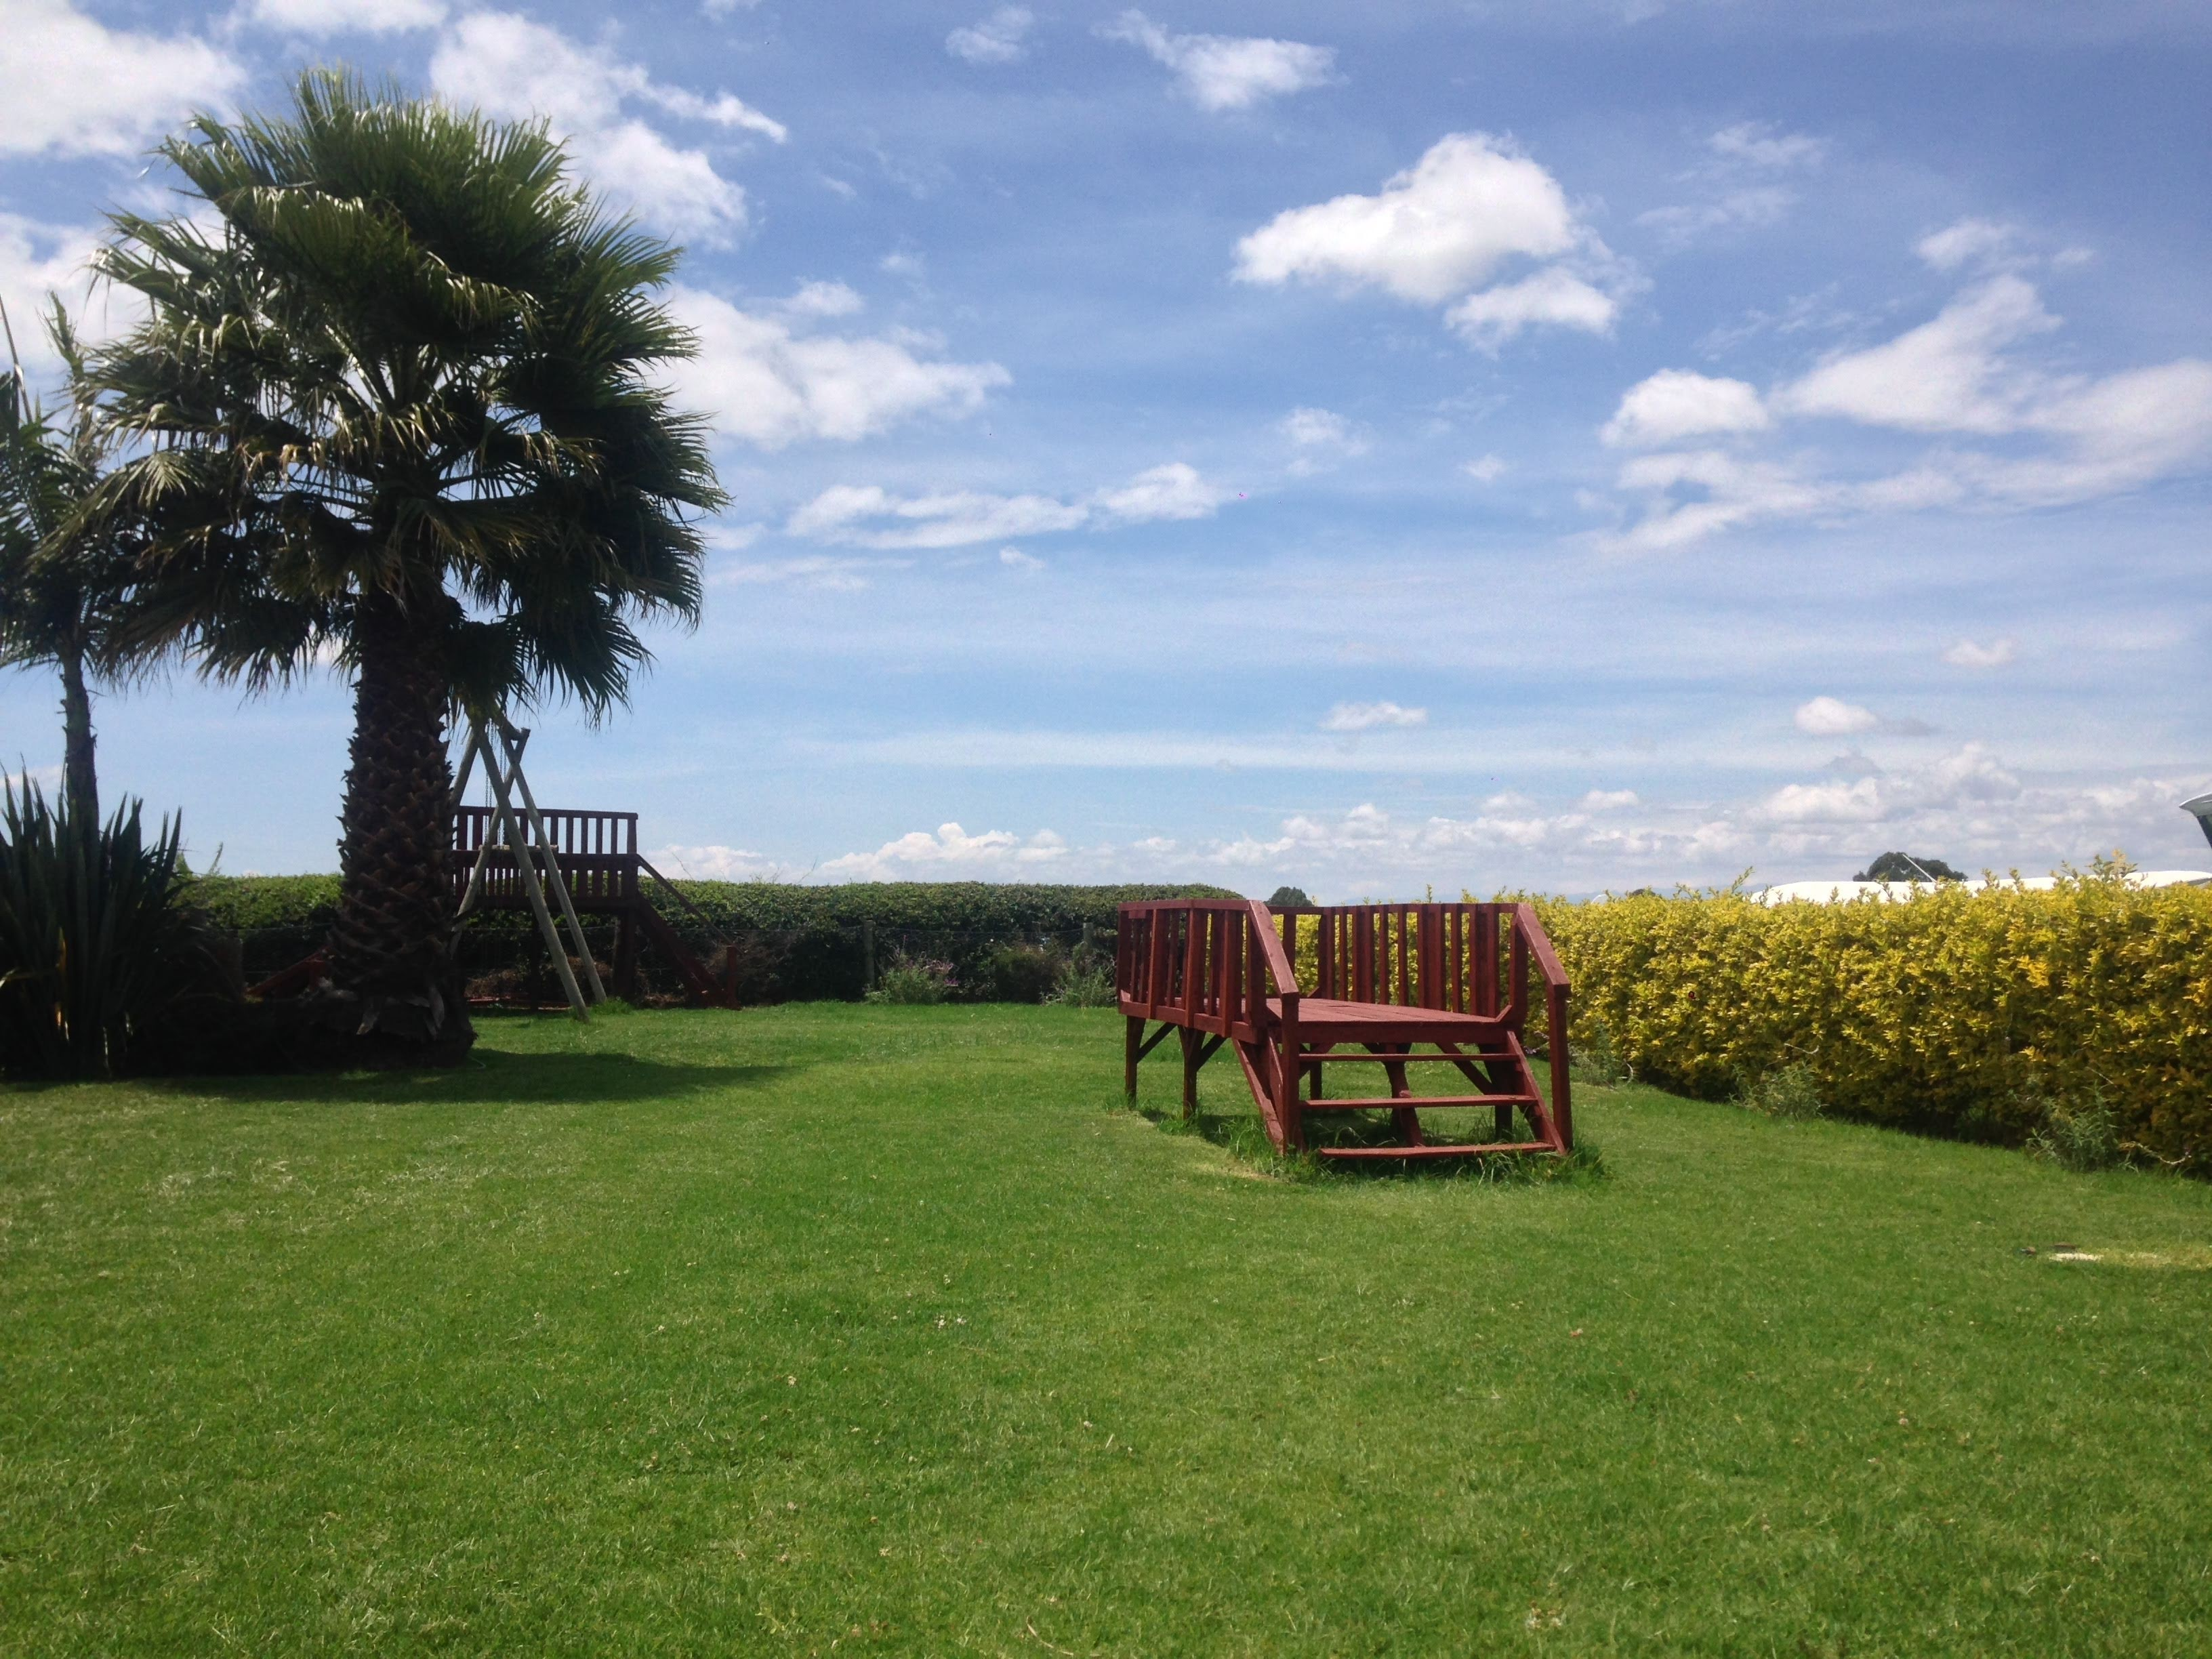

In [19]:
# Let's look at an image
Show(data_path + 'images/nanyuki.jpg', width=600)

Now let's load in and look at that json file of image classifications:

In [0]:
# load in the json file
json_file = json.load(open(data_path+'imagenet_class_index.json'))

classes = [json_file[str(k)][1] for k in range(len(json_file))]

In [14]:
classes[:10]

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

## Load the Model

We're going to use the `ResNet50` version of the various ResNet models.

In [15]:
# Get weights of the model and add nn.LogSoftmax(dim=1) to the end
model_name = 'resnet50'
model = models.resnet50(pretrained=True)
model = nn.Sequential(model, nn.LogSoftmax(dim=1))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


In [0]:
# Transformation to apply to image before prediction (center crop)
# tfms = get_transforms() is possible too
tfms = [ [], [crop_pad()] ]

In [0]:
# Get an empty databunch with the ImageNet classes
# WARNING single_from_classes is deprecated (https://docs.fast.ai/vision.data.html#ImageDataBunch.single_from_classes)
data = ImageDataBunch.single_from_classes(data_path, classes, ds_tfms=tfms, size=224).normalize(imagenet_stats)

In [0]:
# Get the learner of the model
learn = Learner(data, model)

## Make a prediction for one image

In [0]:
# grab an image
img = open_image(data_path + 'images/IMG_8027.JPG')

In [0]:
img.show()

In [0]:
pred_class, pred_idx, prediction_list = learn.predict(img)


In [0]:
print(pred_class)

In [0]:
# this is it's confidence
print(round(float(prediction_list[pred_idx] ),2))

## Make a prediction for all the images

In [0]:
# Get the list of files
image_files = os.listdir(data_path + 'images')
print(image_files)

In [0]:
# Loop through the list of files
for file in image_files:
    
    img = open_image(data_path + 'images/' + file)
    
    pred_class, pred_idx, prediction_list = learn.predict(img)
    confidence = str(round(float(prediction_list[pred_idx]),2))
    
    # print the file name and the category guess
    print(file, pred_class, confidence)

### How did we do?

In [0]:
# Loop through the list of files
for file in image_files:
    
    image_filename = data_path + 'images/' + file
    
    img = open_image(image_filename)
    
    pred_class, pred_idx, prediction_list = learn.predict(img)
    confidence = str(round(float(prediction_list[pred_idx]),2))

    print(f'\n{str(pred_class)} - confidence: {confidence} - {file}')
    display(Show(filename=image_filename, retina=True))